In [1]:
import cv2
from cv2_plt_imshow import cv2_plt_imshow
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import random
from tqdm import tqdm

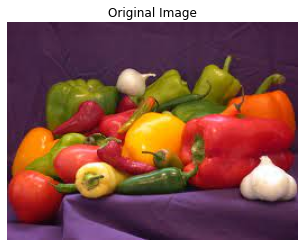

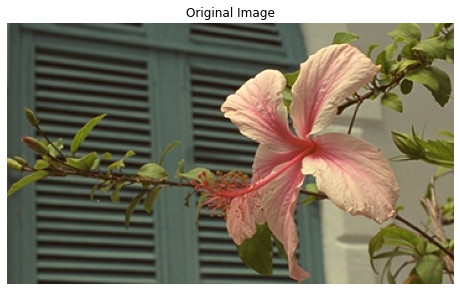

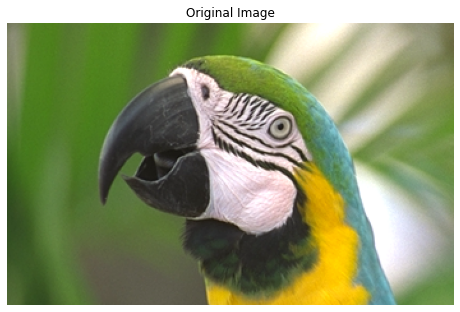

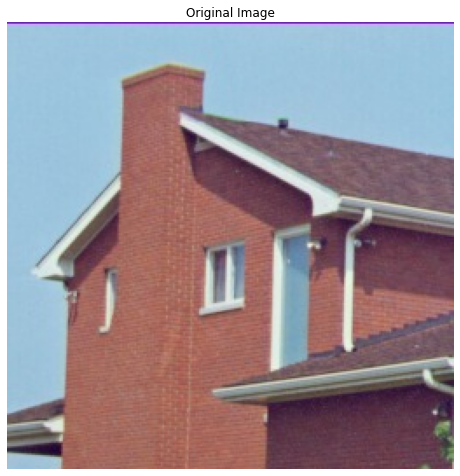

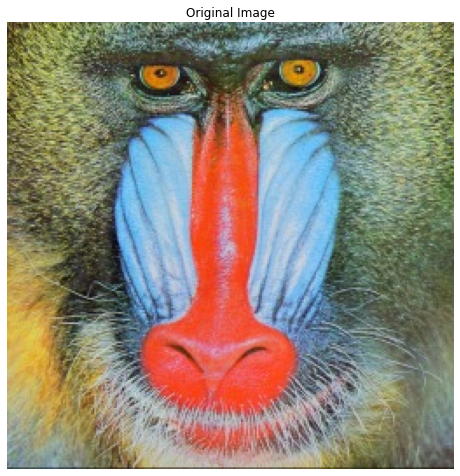

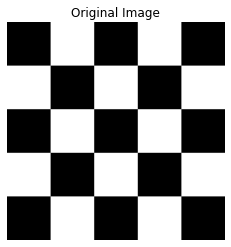

In [2]:
root = "data/"
flower = cv2.imread(root+'flower.png')
pepper = cv2.imread(root+'pepper.png')
parrot = cv2.imread(root+'parrot.png')
house = cv2.imread(root+'house.jpg')
monkey = cv2.imread(root+'monkey.jpg')
cb = cv2.imread(root+"checkerboard.png")

cv2_plt_imshow(pepper)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,10))
cv2_plt_imshow(flower)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,10))
cv2_plt_imshow(parrot)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,10))
cv2_plt_imshow(house)
plt.title("Original Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(8,10))
cv2_plt_imshow(monkey)
plt.title("Original Image")
plt.axis('off')
plt.show()

cv2_plt_imshow(cb)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [3]:
def GaussKernel(x,centre,sigma):
    return np.exp(-np.square(np.linalg.norm(centre-x,axis=1))/(2*sigma**2))

In [4]:
def calKernel(X,X_bar,sigmaS,sigmaR):
    ks = GaussKernel(X[:,0:2],X_bar[:,:2],sigmaS)
    kr = GaussKernel(X[:,2:],X_bar[:,2:],sigmaR)
    K = np.multiply(ks,kr)
    return np.dot(K.reshape(1,X.shape[0]),X)/np.sum(K)

In [5]:
def displayImage(image,Title):
    h,w,d = image.shape
    #left limit
    for i in range(w):
        if np.sum(image[:,i,:]) > 0:
            break
    #right limit
    for j in range(w-1,0,-1):
        if np.sum(image[:,j,:]) > 0:
            break
    cropped = image[:,i:j+1,:].copy()
    plt.figure(figsize=(8,10))
    plt.axis('off')
    plt.title(Title)
    cv2_plt_imshow(cropped)
    plt.show()

In [6]:
def meanShift(im,winSize,spatial,intensity):
    image = cv2.copyMakeBorder(im, (int)(winSize/2),(int)(winSize/2), (int)(winSize/2), (int)(winSize/2), cv2.BORDER_CONSTANT)
    image2 = np.copy(image)
    beg = time.time()
    padValue = 11
    winSize = 23
    dim = 5
    FinalValues = []
    for i in range(image.shape[0]-winSize):
        for j in range(image.shape[1]-winSize):
            temp = image[i:i+winSize,j:j+winSize]
            X = []
            for p in range(temp.shape[0]):
                for q in range(temp.shape[1]):
                    X.append((i+p,q+j,temp[p][q][0],temp[p][q][1],temp[p][q][2]))

            Z = np.array(X)
            Z_bar = Z.reshape((winSize,winSize,dim))[(int)(winSize/2)][(int)(winSize/2)].reshape(1,dim)

            for k in range(40):
                Z_bar = calKernel(Z,Z_bar,spatial,intensity)

            Z_bar = Z_bar.astype(int)
            image2[i+(int)(winSize/2)][j+(int)(winSize/2)] = np.copy(Z_bar[:,2:])
            FinalValues.append(Z_bar)

        if i ==(int)((image.shape[0]-winSize)/3):
            e1 = time.time()
            print("33% execution complete! Time elapsed = ",(e1-beg)/60,"Minutes ",(e1-beg)%60,"Sec")

        if i ==(int)((image.shape[0]-winSize)/2):
            e2 = time.time()
            print("50% execution complete! Time elapsed = ",(e2-beg)/60,"Minutes ",(e2-beg)%60,"Sec")

        if i ==(int)((image.shape[0]-winSize)*0.75):
            e3 = time.time()
            print("75% execution complete! Time elapsed = ",(e3-beg)/60,"Minutes ",(e3-beg)%60,"Sec")

    end = time.time()
    print("\nMean shift Execution complete!\n")
    print("Time taken (in sec) = ",end-beg," Seconds")
    print("Time taken (in min) = ",(end-beg)/60," Minutes",(end-beg)%60,"Sec")       
    return FinalValues,image2

In [7]:
def CentroidGenerator(upValue,k):
    #an empty list to append randomly generated numbers
    #Will be called only the once for any k
    Centroid = []
    while True:
        C1 = random.randrange(0, upValue)
        if C1 not in Centroid:
            Centroid.append(C1)
        else:
            pass
        if len(Centroid) == k:
            return Centroid

In [8]:
def findClusters(yj, h):
    clus = np.zeros(len(yj)) - 1
    clusterNo = 0
    for i in range(len(clus)):
        if(clus[i]<0):
            clus[i] = clusterNo
            count = 1
            for j in range(len(clus)):
                if(clus[j]<0):
    
                    flag = True
                    dis = np.linalg.norm(yj[i] - yj[j])
                    if(dis<=h):
                        clus[j] = clusterNo
                        # if(clusterNo==0):
                        #   print(j)
                        count+=1
            # print(count)
            clusterNo+=1
    return clus, clusterNo

In [9]:
def Clustering(FinalValues,image2,dim):
    k = 45
    beg = time.time()
    image3 = np.copy(image2)
    Centres=[]

    Idx = CentroidGenerator(len(FinalValues),k)
    for i in range(len(Idx)):
        Centres.append(FinalValues[Idx[i]])

    Centres = np.array(Centres).reshape(len(Idx),dim)
    Pixels = np.array(FinalValues).reshape(len(FinalValues),dim)

    for iterations in range(30):
        ArrayCluster = []
        for i in range(k):
            ArrayCluster.append([])

        for i in range(Pixels.shape[0]):
            ArrayCluster[np.argmin(np.linalg.norm((Pixels[i]-Centres),axis=1))].append(Pixels[i])  

        for i in range(k):
            Centres[i] = (np.mean(ArrayCluster[i],axis=0))
    
    for i in range(k):
        for j in range(len(ArrayCluster[i])):
            image3[ArrayCluster[i][j][0]][ArrayCluster[i][j][1]] = np.copy(Centres[i][2:])
    
    end = time.time()
    print("Clustering complete!\n")
    print("Time taken (in sec) = ",end-beg," Seconds")
    print("Time taken (in min) = ",(int)((end-beg)/60)," Minutes",(end-beg)%60,"Sec")
    return image3

33% execution complete! Time elapsed =  8.970967364311218 Minutes  58.258041858673096 Sec
50% execution complete! Time elapsed =  13.717378600438435 Minutes  43.04271602630615 Sec
75% execution complete! Time elapsed =  23.76443378130595 Minutes  45.866026878356934 Sec

Mean shift Execution complete!

Time taken (in sec) =  2099.5861854553223  Seconds
Time taken (in min) =  34.99310309092204  Minutes 59.586185455322266 Sec


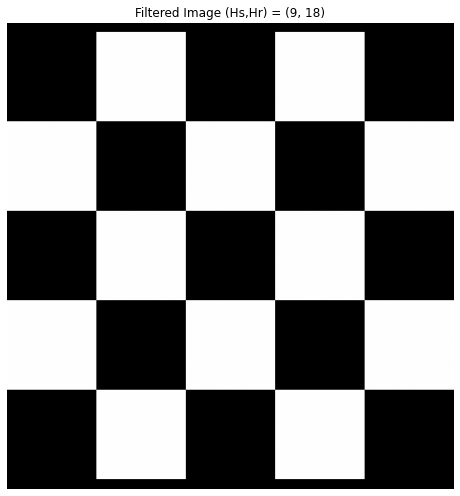

Clustering complete!

Time taken (in sec) =  238.47521591186523  Seconds
Time taken (in min) =  3  Minutes 58.475215911865234 Sec


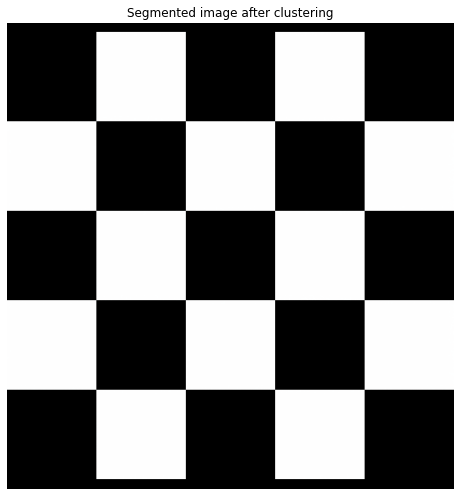

In [10]:
window = 23
sigmaS = 9
sigmaR = 18
dim = 5
FinalValues_flower, image_flower = meanShift(cb,window,sigmaS,sigmaR)
displayImage(image_flower,"Filtered Image (Hs,Hr) = ("+(str)(sigmaS)+", "+(str)(sigmaR) + ")")

image_title = "Segmented image after clustering"
displayImage(Clustering(FinalValues_flower,image_flower,dim),image_title)
